In [1]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 2.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630207 sha256=595a87dcaf255166ad29169ae934f30a62ad0f33a22c2141d9467766370155e9
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd 
import numpy as np
import math
import re 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


## data loading


In [3]:
cb1_path ='/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_1.txt'
# cb2_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_2.txt'
# cb3_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_3.txt'
# cb4_path ='/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_4.txt'

In [4]:
# usecols : 사용할 컬럼
df1 =  pd.read_csv(cb1_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df2 =  pd.read_csv(cb2_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 =  pd.read_csv(cb3_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 =  pd.read_csv(cb4_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [5]:
df1

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [7]:
print(df1.dtypes)
print("=======")
# print(df2.dtypes)
# print("=======")
# print(df3.dtypes)
# print("=======")
# print(df4.dtypes)

Cust_Id     object
Rating     float64
dtype: object


In [8]:
df1['Rating'] = df1['Rating'].astype(float)
# df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

In [9]:
print('Dataset 1 shape : {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape : (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [10]:
df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

In [11]:
df.index = np.arange(0,len(df))

## data viewing

In [12]:
p = df.groupby('Rating')['Rating'].agg(['count'])

In [13]:
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [14]:
print(df.isnull().sum())

print(df.isnull().sum()[1])

Cust_Id       0
Rating     4499
dtype: int64
4499


In [15]:
movie_count = df.isnull().sum()[1]

In [16]:
df['Cust_Id'].nunique()

475257

In [17]:
cust_count = df['Cust_Id'].nunique() - movie_count
rating_count = df['Cust_Id'].count() - movie_count

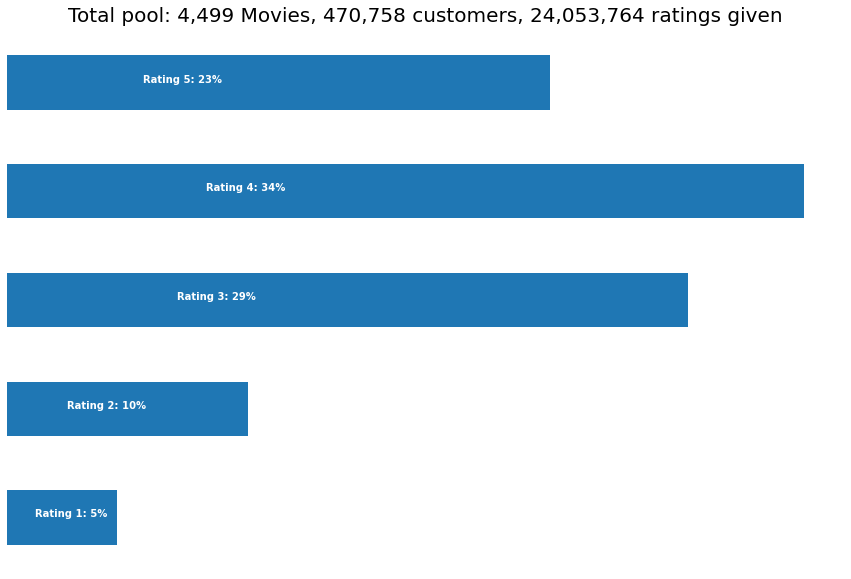

In [18]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15, 10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## data cleansing

In [19]:
df.Rating

0           NaN
1           3.0
2           5.0
3           4.0
4           4.0
           ... 
24058258    2.0
24058259    2.0
24058260    5.0
24058261    3.0
24058262    3.0
Name: Rating, Length: 24058263, dtype: float64

In [20]:
# dataframe에 null값 확인
pd.isnull(df.Rating)

0            True
1           False
2           False
3           False
4           False
            ...  
24058258    False
24058259    False
24058260    False
24058261    False
24058262    False
Name: Rating, Length: 24058263, dtype: bool

In [21]:
pd.DataFrame(pd.isnull(df.Rating))

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


In [22]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))

In [23]:
# nan인것만으로 데이터 프레임 만들기
df_nan[df_nan['Rating'] == True]

,Rating
0,True
548,True
694,True
2707,True
2850,True
...,...
24046714,True
24047329,True
24056849,True
24057564,True


In [24]:
df_nan = df_nan[df_nan['Rating'] == True]

In [25]:
# 인덱스 초기화
df_nan = df_nan.reset_index()

In [26]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [27]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [28]:
movie_np = []
movie_id = 1
# np.full((1,10), 2) : 1 부터 10 총 10개를 2로 채운다
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [29]:
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [30]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# data slicing

In [31]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [32]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 52.0


In [33]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [34]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [35]:
title_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/movie_titles.csv'

In [36]:
df_title = pd.read_csv(title_path, encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# recommend with CF

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?", 0)